# Demo de  Deep Convolutional Generative Adversarial Networks (GAN) para generar imágenes
Basado en:

 https://keras.io/examples/generative/conditional_gan/ 

 https://www.tensorflow.org/tutorials/generative/dcgan?hl=es-419

 https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b


In [1]:
#@title Librerías a usar
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils

import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import random
import copy

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import ipywidgets as widgets
from ipywidgets import Box, Layout

from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


In [2]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


In [3]:
#@title Cargar imágenes

#@markdown ### Parámetros para imágenes:
imagen_ancho_y_ancho = 28#@param {type:"integer"}
#@markdown  Nota: usar un tamaño múltiplo de 4 para que se puedan generar automáticamente las capas de GAN-Generator.
imagen_color = False #@param {type:"boolean"}
incluir_imagenes_generadas_con_data_augmentation = False #@param {type:"boolean"}
usar_imagenes_prueba_para_entrenar = True #@param {type:"boolean"}

# indica si se usan las imágenes generadas por data augmentation
usarDA = incluir_imagenes_generadas_con_data_augmentation

# tamaño de las imágenes
if imagen_ancho_y_ancho<=16:
  imagen_ancho_y_ancho = 16
while (imagen_ancho_y_ancho % 4) != 0:
  imagen_ancho_y_ancho = imagen_ancho_y_ancho + 1
IMAGE_SHAPE = (imagen_ancho_y_ancho, imagen_ancho_y_ancho, (3 if imagen_color else 1))

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            if usarDA or (not esImagDA): 
                
                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)
                
                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:              
                  tipoImage = 'L'
                else:                
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
                
                # transforma a un vector de nros
                arImag = np.array(imag)
                
                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)

if usar_imagenes_prueba_para_entrenar:
  # agregar imágenes de prueba para entrenar
  # sino se descartan
  classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
  classes_train.extend(classes_test)
  images_train.extend(images_test) 
  esDAimag_train.extend(esDAimag_test)

print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
##classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
##print("\n\n> Para Prueba: ")
##print("- Clases cargadas: ", len(np.unique(classes_test)))
##print("- Imágenes cargadas: ", len(images_test))

##if len(classes_test)>0:
##  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
##  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  300
- Ejemplo  0   (28, 28) : 


> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (300, 28, 28, 1)
 		 con valores entre  -1.0  y  1.0
 - y_trainEnc (cant):  300
 - y_train (cant):  300

 - dictMapeo:  {'3': 0, '1': 1, '0': 2, '8': 3, '5': 4, '2': 5, '4': 6, '7': 7, '9': 8, '6': 9}
 - clases_map:  ['3', '1', '0', '8', '5', '2', '4', '7', '9', '6']

 - Imagen reconstruida de  0 ( 2  /  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] )


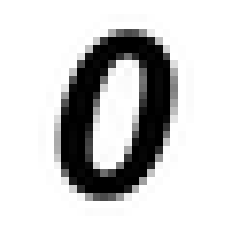

In [4]:
#@title Preparar imágenes para usar en el modelo

# Función auxiliar para guardar información para cálculo de métricas de Discriminator
def defClaseMetricasDisc(esImgReal):
  if esImgReal:
    res = "ImgReal"    
  else:
    res = "ImgGenerada"
  return res

# función auxiliar para mostar imágenes 
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow(imag[:, :, 0], cmap='gray')
  else:    
    imag = np.array((imag*127.5) + 127.5, np.uint8)
    plt.imshow(imag)
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') #/ 255.
  auxiAr = (auxiAr - 127.5) / 127.5  # Normalize the images to [-1, 1]
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))  
  return auxiAr
  
# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
##x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
##y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)
y_test, y_testEnc = [], []

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" \t\t con valores entre ",  np.min(x_train) , " y " ,  np.max(x_train) )
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))


##print("\n\n> Para Prueba: ")
##print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
##print(" - y_testEnc (cant): ", len(y_testEnc))
##print(" - y_test (cant): ", len(y_test))
##print("\n\n> Para Ambos: ")
print("")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

In [13]:
#@title Establecer modelo GAN 

#@markdown ###  Parámetros para GAN:
gan_tipo = "cGAN - con clases" #@param ["GAN", "cGAN - con clases"]
gan_cantidad_dimensiones_semilla = 256 #@param {type: "integer"}
gan_agregar_ruido_imagenes_entrenamiento = False #@param {type: "boolean"}

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.0002 #@param {type: "number"}

# aplica configuración
if gan_tipo[:4] == "cGAN":
  gan_incluir_input_clases = True
else:
  gan_incluir_input_clases = False

if gan_cantidad_dimensiones_semilla < 5:
  gan_cantidad_dimensiones_semilla = 5

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()


class GAN(keras.Model):
    def __init__(self, seed_dim, image_shape, add_noise_images_train=False, include_classes_info=None):        
        self.include_classes = not(include_classes_info is None)
        if self.include_classes:
          auxName = "CGAN"
        else:
          auxName = "GAN"
        super().__init__(name=auxName)
        self.seed_dim = seed_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.image_shape = image_shape       
        self.add_noise_images_train = add_noise_images_train 
        self.classes_info = include_classes_info # puede forma (tupla) o cantidad de clases (nro)
        self.generator = self.createGeneratorModel(auxName)
        self.discriminator = self.createDiscriminatorModel(auxName)

    def addClassLayers(self, targetShape, subModelName):
        # determina si el target es imagen o no
        targetEsImg = isinstance(targetShape, tuple) and (len(targetShape)==3)
        if isinstance(self.classes_info, tuple) and (len(self.classes_info) > 1):
          # agrega capa de entradas para clase como vector de números
          inputLay_class = tf.keras.layers.Input(shape=self.classes_info, name="input-class")
          eachLay = inputLay_class          
          # determina si agrega ceros para completar tamaño
          if targetEsImg:
            auxShapePadding = targetShape[1]
          else:
            auxShapePadding = targetShape
          zerosAgregarClases =  auxShapePadding - self.classes_info
          if zerosAgregarClases < 0:
              raise Exception("La forma de las clases " + str(self.classes_info) +" no es compatible con la forma" + str(targetShape)+ " para definir submodelo " + subModelName + "!")
              return None, None
          elif zerosAgregarClases > 0:           
              # agrega ceros para completar el tamaño
              eachLay = tf.keras.layers.Reshape([-1, 1], name="class-reshape-aux1")(eachLay)
              eachLay = tf.keras.layers.ZeroPadding1D(padding=(0, zerosAgregarClases), name="class-paddZeros")(eachLay)
              eachLay = tf.keras.layers.Reshape([-1], name="class-reshape-aux2")(eachLay)
          if targetEsImg:
              # cambia la forma agregando copias del vector
              eachLay = tf.keras.layers.RepeatVector(targetShape[0]*targetShape[2], name="class-repeat")(eachLay)                        
              eachLay = tf.keras.layers.Reshape(targetShape, name="class-reshape-img")(eachLay)
          else:  
            eachLay = tf.keras.layers.Reshape((targetShape,), name="class-reshape-seed")(eachLay)
          # nota: el último reshape no sería necesario pero lo hago por las dudas
        else:
          # agrega capa de entradas para clase como número (más sencillo)
          inputLay_class = tf.keras.layers.Input(shape=(1,), name="input-class")
          eachLay = inputLay_class
          if  (self.classes_info <= 0):
            n_classes = 100
          else:
            n_classes = self.classes_info
          # usa Embedding para generar vectores que codifican la clase
          eachLay = tf.keras.layers.Embedding(n_classes, 50, name="class-embedding")(eachLay)
          # agrega neuronas para ajustar la forma
          if targetEsImg:
            n_nodes = targetShape[0] * targetShape[1] * targetShape[2]
          else:
            n_nodes = targetShape
          eachLay = tf.keras.layers.Dense(n_nodes, name="class-lineal")(eachLay)
          # ajusta la forma
          if targetEsImg:
            eachLay = tf.keras.layers.Reshape(targetShape, name="class-reshape-img")(eachLay)
          else:
            eachLay = tf.keras.layers.Reshape((targetShape,), name="class-reshape-seed")(eachLay)
        return inputLay_class, eachLay

    def createDiscriminatorModel(self, auxName="GAN"):              
        # define capas para GAN discriminator
        inputLay_img = tf.keras.layers.Input(shape=self.image_shape, name='input-img')
        eachLay = inputLay_img
        if self.add_noise_images_train:
          # agrega capa para agregar ruido al azar
          eachLay = tf.keras.layers.GaussianNoise(0.1, name="rndmNoise")(eachLay)
        if self.include_classes:
          # agrega capa de entrada con a clase
          # que se transforma para que tenga misma forma que imagen
          # y luego se concatena                  
          inputLay_class, eachLay2 = self.addClassLayers(self.image_shape, "Discriminator")
          eachLay = tf.keras.layers.concatenate([eachLay, eachLay2], name="MergeInputs")          
        eachLay = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', name="conv_1")(eachLay)
        eachLay = tf.keras.layers.LeakyReLU(name="ReLU_1")(eachLay)
        eachLay = tf.keras.layers.Dropout(0.3, name="d_1")(eachLay)
        eachLay = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name="conv_2")(eachLay)
        eachLay = tf.keras.layers.LeakyReLU(name="ReLU_2")(eachLay)
        eachLay = tf.keras.layers.Dropout(0.3, name="d_2")(eachLay)
        eachLay = tf.keras.layers.Flatten(name="flat")(eachLay)
        ouputLay = tf.keras.layers.Dense(1, name="output-disc")(eachLay)
        # define modelo para GAN discriminator
        if self.include_classes:
            model = keras.Model(
              inputs = [inputLay_img, inputLay_class], 
              outputs = ouputLay, 
              name = auxName+"-Discriminator")                
        else:
            model = keras.Model(
              inputs = inputLay_img, 
              outputs = ouputLay, 
              name = auxName+"-Discriminator")                
        return model

    def createGeneratorModel(self, auxName="GAN"):  
        # define capas para GAN generator
        inputLay_seed = tf.keras.layers.Input(shape=(self.seed_dim,), name='input-seed')
        eachLay = inputLay_seed
        if self.include_classes:
          # agrega capa de entrada con clase 
          # que se transforma para que tenga misma forma que seed
          # y luego se concatena
          inputLay_class, eachLay2 = self.addClassLayers(self.seed_dim, "Generator")
          eachLay = tf.keras.layers.concatenate([eachLay, eachLay2], name="MergeInputs")
        # calcula valores iniciales capas para generar imágen de forma self.image_shape
        iniImgNodeDim = (self.image_shape[0]//4, self.image_shape[1]//4, self.image_shape[2])
        if (iniImgNodeDim[0] < 1) or (iniImgNodeDim[1] < 1):
            raise Exception("No se puede generar " + auxName+"-Generator porque el tamaño de las imágenes es muy pequeño: " + str(self.image_shape)+ "!")
            return None
        # determina cantidad de neuronas para capa inicial de forma que genere la imagen
        # con el tamaño deseado (self.image_shape)
        # ejemplo ini 8x8x256 -> output 32x32x1
        # ejemplo ini 7*7*256 -> output 28x28x1
        n_nodes = iniImgNodeDim[0] * iniImgNodeDim[1] * 256
        eachLay = tf.keras.layers.Dense(n_nodes, use_bias=False, name="lineal_1")(eachLay)
        eachLay = tf.keras.layers.BatchNormalization(name="bn_1")(eachLay)
        eachLay = tf.keras.layers.LeakyReLU(alpha=0.2, name="ReLU_1")(eachLay)
        eachLay = tf.keras.layers.Reshape((iniImgNodeDim[0], iniImgNodeDim[1], 256), name="reshape_1")(eachLay)
        eachLay = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, name="convTsp_1")(eachLay)
        eachLay = tf.keras.layers.BatchNormalization(name="bn_2")(eachLay)
        eachLay = tf.keras.layers.LeakyReLU(alpha=0.2, name="ReLU_2")(eachLay)
        eachLay = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, name="convTsp_2")(eachLay)
        eachLay = tf.keras.layers.BatchNormalization(name="bn_3")(eachLay)
        eachLay = tf.keras.layers.LeakyReLU(alpha=0.2, name="ReLU_3")(eachLay)
        ouputLay = tf.keras.layers.Conv2DTranspose(iniImgNodeDim[2], (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', name="output")(eachLay)
        # define modelo para GAN generator
        if self.include_classes:
            model = keras.Model(
              inputs = [inputLay_seed, inputLay_class],
              outputs = ouputLay, 
              name = auxName+"-Generator")              
        else:
            model = keras.Model(
              inputs = inputLay_seed, 
              outputs = ouputLay, 
              name = auxName+"-Generator")              
        # controla que la  salidas sea igual al IMAGE_SHAPE
        for i in range(3):
          if self.image_shape[i] != ouputLay.shape[i+1]:
            raise Exception("La cantidad de salidas de " + auxName+"-Generator " + str(ouputLay.shape)+ " no coincide con la forma de las imágenes " + str(self.image_shape)+ "!")
            return None
        return model

    def summary(self):
      # para mostrar modelo GAN
      print("\nModelo " + self.name + " creado:")
      self.generator.summary()
      print("\n")
      self.discriminator.summary()
      print("\n")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, discriminator_optimizer=None, generator_optimizer=None):
      # compila el modelo GAN
      super().compile()
      if discriminator_optimizer is None:
        self.discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
      else:
        self.discriminator_optimizer = discriminator_optimizer
      if generator_optimizer is None:
        self.generator_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
      else:
        self.generator_optimizer = generator_optimizer
      self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def discriminator_loss(self, real_output, fake_output):
      # calcula error Disciminator
      real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
      fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss * 0.5 # para que pese la mitad

    def generator_loss(self, fake_output):
      # calcula error Generator
      return self.loss_fn(tf.ones_like(fake_output), fake_output)

    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step(self, data):

        if self.include_classes and isinstance(data, tuple):
          # reciben imágenes y clases
          real_images, classes = data
        else:
          # reciben imágenes 
          real_images = data

        # genera semillas para generator
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, self.seed_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generator genera imágenes falsas
          if self.include_classes:
            generated_images = self.generator([noise, classes], training=True)
          else:
            generated_images = self.generator(noise, training=True)
          # le pide a dicriminator que determine si imagenes verdaderas son verdaderas
          if self.include_classes:
            real_output = self.discriminator([real_images, classes], training=True)
          else:
            real_output = self.discriminator(real_images, training=True)
          # le pide a dicriminator que determine si imagenes falsas son verdaderas
          if self.include_classes:
            fake_output = self.discriminator([generated_images, classes], training=True)
          else:
            fake_output = self.discriminator(generated_images, training=True)
          # calcula error en base a resultados del dicriminator
          gen_loss = self.generator_loss(fake_output)
          disc_loss = self.discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # ajusta pesos
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # para monitorear loss
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        return {
            "generator_loss": self.gen_loss_tracker.result(),
            "discriminator_loss": self.disc_loss_tracker.result(),
        }

if gan_incluir_input_clases:
  # puede ser el "shape" de las clases codificadas como vector, o la cantidad de clases
  gan_input_clases_info =  len(clases_map) #y_trainEnc.shape[1]
else:
  gan_input_clases_info = None 

# inicializa modelo
GANmodel = GAN(
    seed_dim = gan_cantidad_dimensiones_semilla,
    image_shape = IMAGE_SHAPE,
    add_noise_images_train = gan_agregar_ruido_imagenes_entrenamiento,
    include_classes_info = gan_input_clases_info
)

# configura optimizer 
GANmodel.compile(
    discriminator_optimizer = opt, 
    generator_optimizer = opt, 
)        

# lo muestra
GANmodel.summary()
print("\n")



Modelo CGAN creado:
Model: "CGAN-Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-class (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 class-embedding (Embedding)    (None, 1, 50)        500         ['input-class[0][0]']            
                                                                                                  
 class-lineal (Dense)           (None, 1, 256)       13056       ['class-embedding[0][0]']        
                                                                                                  
 input-seed (InputLayer)        [(None, 256)]        0           []                               
                                                                

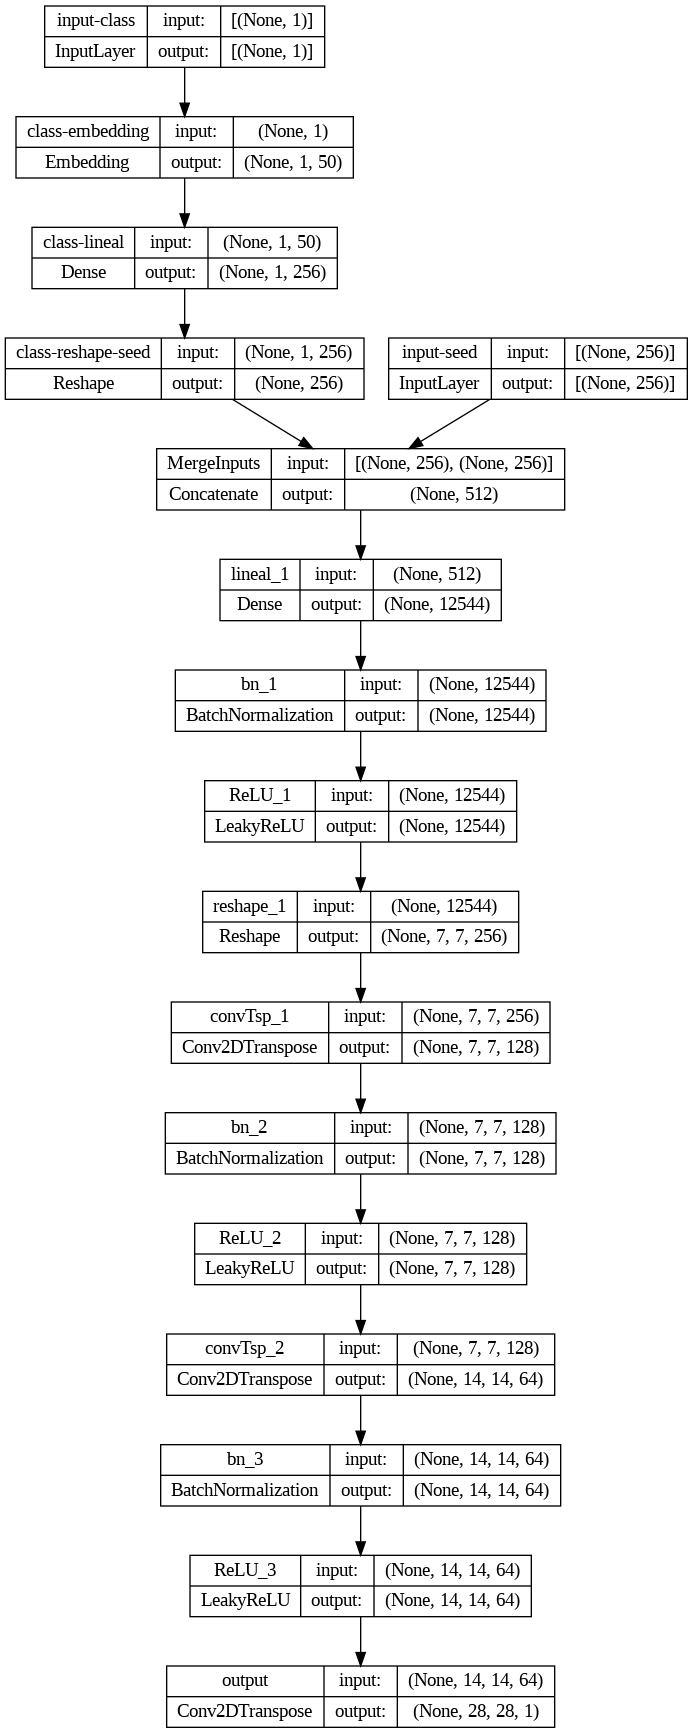

In [14]:
#@title -- Mostrar estrucura de submodelo GAN-Generator
plot_model(GANmodel.generator, show_layer_names=True, show_shapes=True)


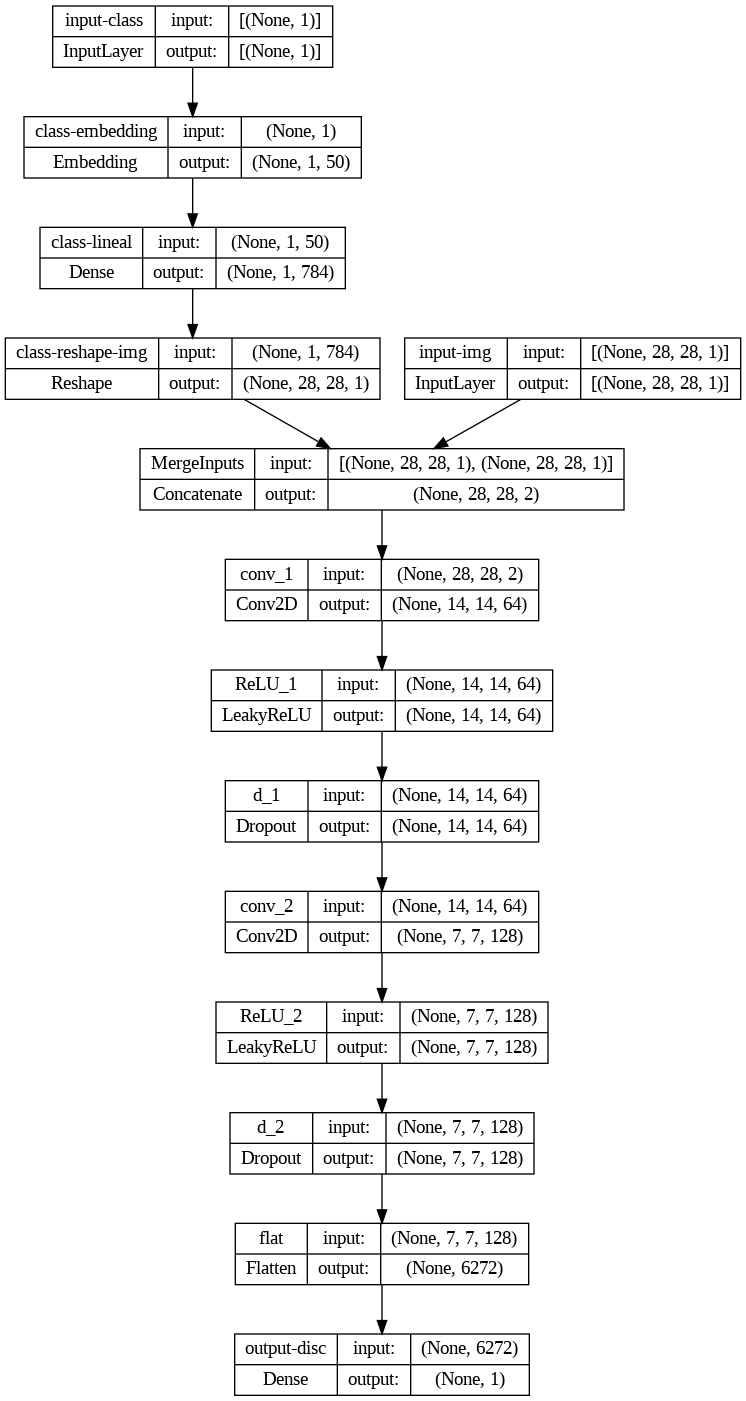

In [15]:
#@title -- Mostrar estrucura de submodelo GAN-Discriminator
plot_model(GANmodel.discriminator, show_layer_names=True, show_shapes=True)


In [16]:
#@title Entrenar submodelos de GAN 

cant_epocas_entrenamiento =  2500 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
if gan_incluir_input_clases:
  # entrena tipo CGAN con clases
  if isinstance(gan_input_clases_info, tuple) and (len(gan_input_clases_info) > 1):
    auxY_train = y_trainEnc
  else:
    auxY_train = y_train
  history = GANmodel.fit(x_train, auxY_train,
                  epochs = cantEpocas,
                  shuffle=True)
else:
  # entrena tipo GAN sin clases
  history = GANmodel.fit(x_train,
                epochs = cantEpocas,
                shuffle=True)

Se han truncado las últimas 5000 líneas del flujo de salida.
10/10 [==============================] - 3s 19ms/step - generator_loss: 0.6371 - discriminator_loss: 0.5763
Epoch 2/2500
10/10 [==============================] - 0s 16ms/step - generator_loss: 0.5516 - discriminator_loss: 0.5007
Epoch 3/2500
10/10 [==============================] - 0s 13ms/step - generator_loss: 0.7515 - discriminator_loss: 0.4261
Epoch 4/2500
10/10 [==============================] - 0s 15ms/step - generator_loss: 0.5513 - discriminator_loss: 0.6529
Epoch 5/2500
10/10 [==============================] - 0s 12ms/step - generator_loss: 1.1360 - discriminator_loss: 0.3923
Epoch 6/2500
10/10 [==============================] - 0s 12ms/step - generator_loss: 2.0353 - discriminator_loss: 0.1144
Epoch 7/2500
10/10 [==============================] - 0s 12ms/step - generator_loss: 1.9650 - discriminator_loss: 0.1422
Epoch 8/2500
10/10 [==============================] - 0s 13ms/step - generator_loss: 1.6058 - discriminat

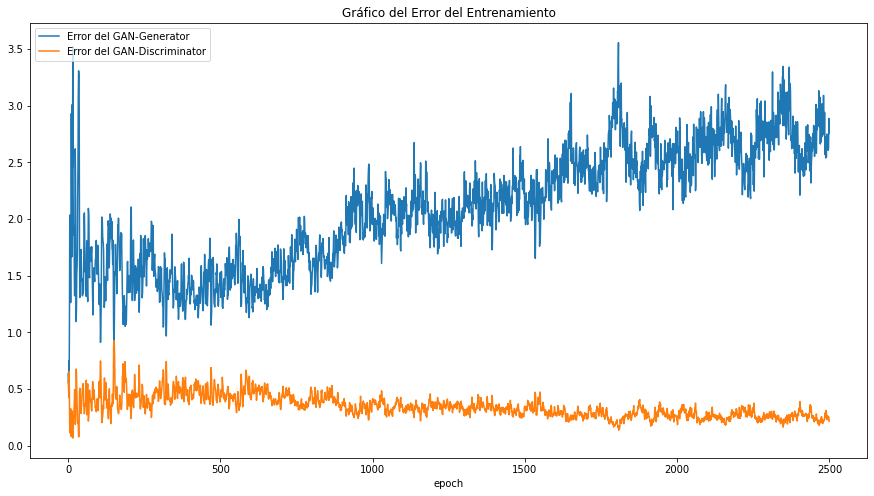

In [17]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['generator_loss'])
plt.plot(history.history['discriminator_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['Error del GAN-Generator', 'Error del GAN-Discriminator'], loc='upper left')
plt.show()



 Resultados de GAN-Generator: 


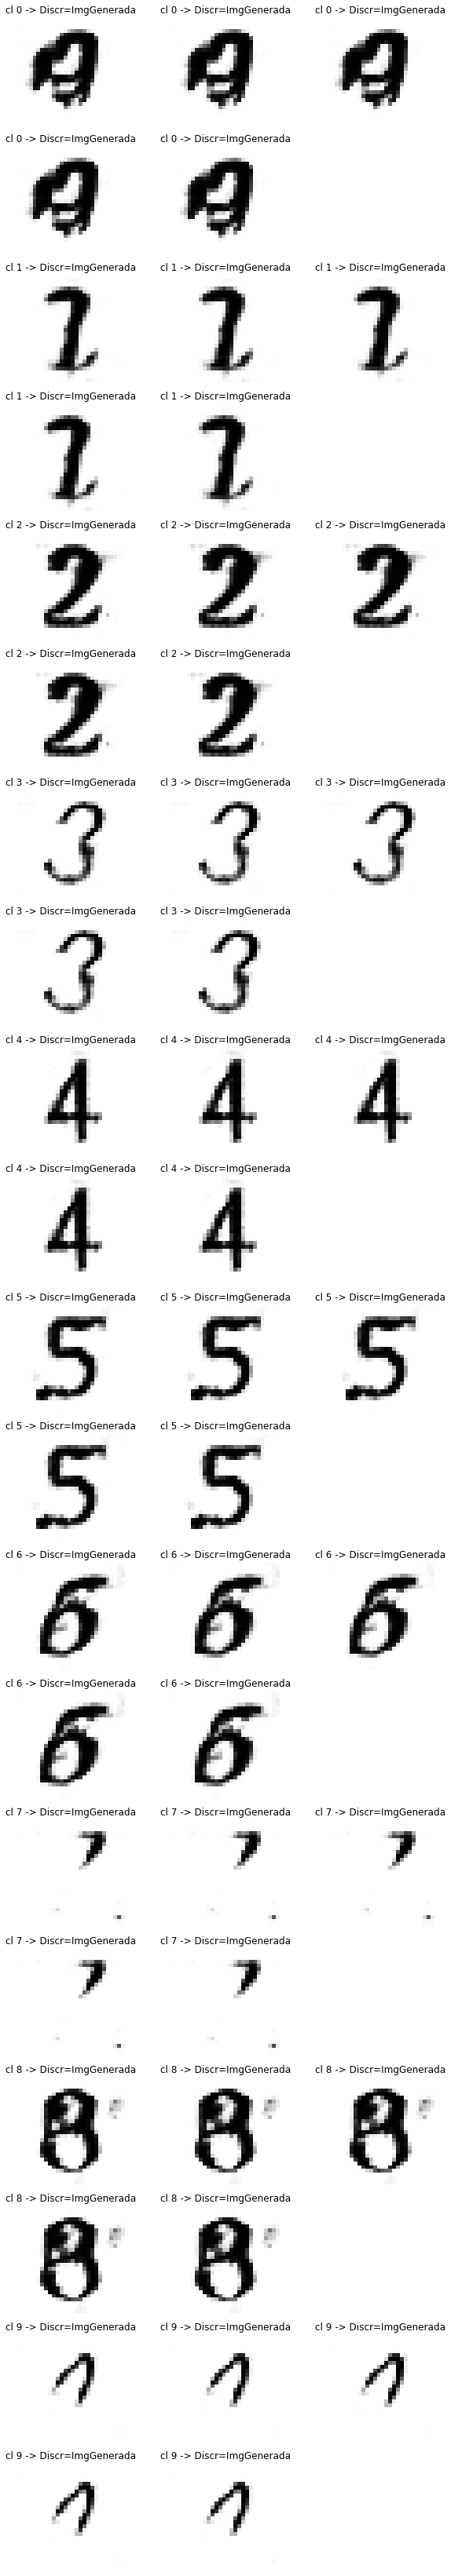

In [18]:
#@title Evaluar sub-modelo GAN-Generator generando imágenes

cant_imagenes_generar = 5 #@param{type:"integer"}

if cant_imagenes_generar < 1:
  cant_imagenes_generar = 1

# inicializa la figura para mostrar imagenes
if gan_incluir_input_clases:
  # determina clases a mostrar
  listaClasesEvaluar = list(dictMapeo.keys())
  listaClasesEvaluar.sort()
else:
  # agrega una dummy para generar sin clase
  listaClasesEvaluar = [ "" ]
cantMostrar = cant_imagenes_generar * len(listaClasesEvaluar)
nCols = 3
nRows = (cant_imagenes_generar // nCols) * len(listaClasesEvaluar)
if (nRows*nCols) < cantMostrar:
  nRows = nRows + cantMostrar - (nRows*nCols)
plt.figure(figsize=(10, 3*nRows))
plt.axis('off')
posImagen = 1

# inicializa para calculo 
# de métricas de Discriminator
disc_classPreds_onlyGenerated = []

# por cada clase a mostrar
print("\n Resultados de GAN-Generator: ")
for cl in listaClasesEvaluar:
  
  # determina si genera por clase  
  if gan_incluir_input_clases:
    # inicializa la clase a procesar    
    if isinstance(gan_input_clases_info, tuple) and (len(gan_input_clases_info) > 1):
      classesX = np.zeros((cant_imagenes_generar, gan_input_clases_shape)) 
      for i in range(cant_imagenes_generar):
        # marca la clase que corresponde
        classesX[i][dictMapeo[cl]] = 1
    else:
      classesX = []
      for i in range(cant_imagenes_generar):
        classesX.append( dictMapeo[cl] )    
    classesX = np.array( classesX )
  else:
    classesX = None    

  # genera semilla para generar imagen
  seedX = tf.random.normal([cant_imagenes_generar, gan_cantidad_dimensiones_semilla])

  #print("Inputs Seed: ", seedX.shape)
  #print("Inputs Clase: ", classesX.shape)

  # ejecuta el modelo Generator
  if classesX is None:
    generated_images = GANmodel.generator(seedX, training=False)
  else:
    generated_images = GANmodel.generator([seedX, classesX], training=False)

  # ejecuta el modelo Discriminator
  if classesX is None:
    discr_decisions = GANmodel.discriminator(generated_images)
  else:
    discr_decisions = GANmodel.discriminator([generated_images, classesX])

  # auxiliar para mostrar
  if cl == "":
    tit = ""
  else:
    tit = "cl " + str(cl) 

  # procesa resultados
  for im, dec in zip(generated_images, discr_decisions):      
      
      # determina resultado de Discriminator
      # guada información para evaluar el modelo        
      resTipoImg = defClaseMetricasDisc(esImgReal=(dec>0)) 
      disc_classPreds_onlyGenerated.append( [resTipoImg, cl] )
      
      # muestra
      ax = plt.subplot(nRows, nCols, posImagen)      
      plot_image(im)
      plt.title( tit + " -> Discr=" + resTipoImg )
      posImagen = posImagen + 1
      plt.axis('off')
  # incrementa para que la siguiente clase aparezca en una nueva línea
  if cant_imagenes_generar > 1:
    while ((posImagen-1) % nCols) != 0:
      posImagen = posImagen + 1

#plt.tight_layout()
fig = plt.gcf()
plt.show()
plt.close(fig) 


In [21]:
#@title Evaluar sub-modelo GANN-Discriminator con imágenes de entrenamiento y las generadas en el paso anterior

mostrar_metricas_por_clase = False #@param{type:"boolean"}

if not gan_incluir_input_clases:
  # no se muestra por clase porque GAN no usa clase
  print("--Como es modelo GAN no se muestra detalle por clase.")
  mostrar_metricas_por_clase = False

# inicializa para cálculo de métricas
disc_classPreds_onlyReals = []

# ejecuta modelo con imágenes reales
if gan_input_clases_info is None:
    discr_decisions = GANmodel.discriminator(x_train)
else:
    if isinstance(gan_input_clases_info, tuple) and (len(gan_input_clases_info) > 1):
      auxY_train = y_trainEnc
    else:
      auxY_train = y_train
    discr_decisions = GANmodel.discriminator([x_train, auxY_train])

# procesa resultados
for dec, cl in zip(discr_decisions, y_train):      
    # determina resultado de Discriminator
    # guarda información para evaluar el modelo
    resMetrica = defClaseMetricasDisc(esImgReal=(dec>0)) 
    disc_classPreds_onlyReals.append( [resMetrica, cl] )


# formatea clases para mostrar
disc_classPreds = []
disc_classReal = []
# formatea resultados de procesar imágenes reales
for vec in disc_classPreds_onlyReals:     
  auxPreds = vec[0]
  auxReal = defClaseMetricasDisc(esImgReal=True) 
  if mostrar_metricas_por_clase:
    auxPreds = auxPreds + "-" + str(vec[1])
    auxReal = auxReal + "-" + str(vec[1])
  disc_classPreds.append( auxPreds )
  disc_classReal.append( auxReal )
# si ya se ejecuto el Generador, 
# agrega métricas obtenidas para imágenes Generadas
if 'disc_classPreds_onlyGenerated' in vars():
  # formatea resultados de procesar imágenes falsas
  for vec in disc_classPreds_onlyGenerated:      
    auxPreds = vec[0]
    auxReal = defClaseMetricasDisc(esImgReal=False) 
    if mostrar_metricas_por_clase:
      auxPreds = auxPreds + "-" + str(vec[1])
      auxReal = auxReal + "-" + str(vec[1])
    disc_classPreds.append( auxPreds )
    disc_classReal.append( auxReal )
# genera lista única    
auxLabels = list(set(disc_classPreds))
for c in disc_classReal:
  if c not in auxLabels:
    auxLabels.append( c )
auxLabels.sort()

# muestra reporte de clasificación
print("\n Reporte de Clasificación para GAN-Discriminator: ")
print(classification_report(disc_classReal, disc_classPreds))

# muestra matriz de confusion
print('\nMatriz de Confusión para GAN-Discriminator ( real / modelo ): ')
cm = confusion_matrix(disc_classReal, disc_classPreds, labels=auxLabels)
cmtx = pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in auxLabels], 
    columns=['m:{:}'.format(x) for x in auxLabels]
  )
cmtx.sort_index(axis=0, inplace=True)
cmtx.sort_index(axis=1, inplace=True)
print(cmtx)
print("\n")         


 Reporte de Clasificación para GAN-Discriminator: 
              precision    recall  f1-score   support

 ImgGenerada       0.72      1.00      0.84        50
     ImgReal       1.00      0.94      0.97       300

    accuracy                           0.95       350
   macro avg       0.86      0.97      0.90       350
weighted avg       0.96      0.95      0.95       350


Matriz de Confusión para GAN-Discriminator ( real / modelo ): 
               m:ImgGenerada  m:ImgReal
r:ImgGenerada             50          0
r:ImgReal                 19        281


